# 0. 사용할 패키지 불러오기

In [114]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers.normalization import BatchNormalization
from tensorflow.python.keras.layers.convolutional import Conv2D
from tensorflow.python.keras.layers.convolutional import MaxPooling2D
from tensorflow.python.keras.layers.core import Activation
from tensorflow.python.keras.layers.core import Flatten
from tensorflow.python.keras.layers.core import Dropout
from tensorflow.python.keras.layers.core import Dense
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.python.keras.models import load_model
from keras.models import model_from_json

# 1. 데이터 불러오기

In [4]:
import numpy as np
import glob
import sys
from sklearn.model_selection import train_test_split

x_train = np.empty((0, 64, 64, 3))
y_train = np.empty((0, 3))
print(y_train.shape)

training_data = glob.glob('/home/pirl/Documents/splited_action_data2/npz_data15/*.npz')
#print(training_data)
idx=1
for single_npz in training_data:
    with np.load(single_npz) as data:
        #print(data.files)
        x = data['train']
        y = data['training_labels']
        #print(x.shape)
    x = np.reshape(x, (-1, 64, 64, 3))
    
    x_train = np.vstack((x_train, x))
    y_train = np.vstack((y_train, y))
    if idx % 2000 ==0:
        print(idx)
    idx+=1
print(x_train.shape)
# train test split, 7:3
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.3, random_state = 42)

y_train = y_train[:,:]
y_test = y_test[:,:]

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(0, 3)
2000
4000
6000
8000
10000
12000
(13883, 64, 64, 3)
(9718, 64, 64, 3) (9718, 3)
(4165, 64, 64, 3) (4165, 3)


# 데이터 확인

In [ ]:
#import pandas as pd

#y_data = pd.DataFrame(y_total[:, :])

In [ ]:
#y_data.count()

In [ ]:
#left = y_data.loc[y_data[:][0] == 1]

In [ ]:
#left.count()

In [ ]:
#right = y_data.loc[y_data[:][1] == 1]

In [ ]:
#right.count()

In [ ]:
#forward = y_data.loc[y_data[:][2] == 1]

In [ ]:
#forward.count()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

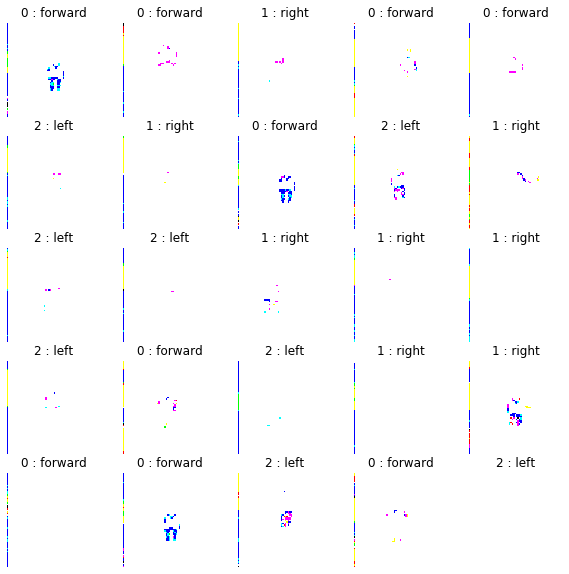

In [81]:
# 데이터 확인

from matplotlib import pyplot as plt
%matplotlib inline

plt_row = 5
plt_col = 5
plt.rcParams["figure.figsize"] = (10,10)

f, axarr = plt.subplots(plt_row, plt_col)

for i in range(plt_row*plt_col):

    sub_plt = axarr[int(i/plt_row), int(i%plt_col)]
    sub_plt.axis('off')
    sub_plt.imshow(x_train[i].reshape(64, 64,3))
    
    label = np.argmax(y_train[i])
                      
    if label == 2 :
        direction = 'left'
    elif label == 1:
        direction = 'right'
    elif label == 0:
        direction = 'forward'
#     elif label == 3:
#         direction = 'backward'
                      
    sub_plt_title = str(label) + " : " + direction
    sub_plt.set_title(sub_plt_title)

plt.show()

# 3. 모델 생성

In [82]:
# image size = 160 x 320
def posla_net():
    
    # model setting
    H = 64
    W = 64
    CH = 3

    inputShape = (H, W, CH)

    activation = 'relu'
    keep_prob_conv = 0.25
    keep_prob_dense = 0.5

    #init = 'glorot_normal'
    #init = 'he_normal'
    init = 'he_uniform'
    chanDim = -1
    classes = 3
    
    model = Sequential()
    
    # CONV => RELU => POOL
    model.add(Conv2D(3, (3, 3), padding="valid", input_shape=inputShape, kernel_initializer=init, activation=activation))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(9, (3, 3), padding="valid", kernel_initializer=init, activation=activation))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(18, (3, 3), padding="valid", kernel_initializer=init, activation=activation))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(32, (3, 3), padding="valid", kernel_initializer=init, activation=activation))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    
    model.add(Dense(80, kernel_initializer=init, activation=activation))
    model.add(Dropout(keep_prob_dense))
    
    model.add(Dense(15, kernel_initializer=init, activation=activation))
    model.add(Dropout(keep_prob_dense))
    
    # softmax classifier
    model.add(Dense(classes , activation = 'softmax'))
    
    return model


In [83]:
model = posla_net()
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 62, 62, 3)         84        
_________________________________________________________________
batch_normalization_7 (Batch (None, 62, 62, 3)         12        
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 31, 31, 3)         0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 29, 29, 9)         252       
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 14, 14, 9)         0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 12, 12, 18)        1476      
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 6, 6, 18)         

In [84]:
from tensorflow.python.keras.utils import plot_model
plot_model(model, to_file= 'video_net_plot.png', show_shapes = True, show_layer_names = True)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


# 4. 모델 파라미터 셋팅

적은 수의 이미지 데이터가 존재할 경우 데이터를 늘리는 용도로 사용

In [85]:
aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
    horizontal_flip=True, fill_mode="nearest")

In [86]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

In [87]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.0001)

In [88]:
# initialize the model
# EPOCHS = 50
# INIT_LR = 1e-3
# BS = 32
# split_ratio = 0.2

In [89]:
EPOCHS = 50
INIT_LR = 1e-4
BS = 256
split_ratio = 0.2

print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt,
    metrics=["accuracy"])
 

[INFO] compiling model...


# 5. 모델 훈련

In [90]:
from tensorflow.keras.utils import to_categorical


In [91]:
y_binary = to_categorical(y_train)

In [92]:
hist = model.fit(x_train, y_train,
                 epochs=EPOCHS, validation_steps=BS, 
                 validation_split=split_ratio, 
                 verbose = 1
                 ,callbacks=[reduce_lr]
                )

Train on 7774 samples, validate on 1944 samples
Epoch 1/50
7774/7774 [==============================] - 282s 36ms/sample - loss: 9.1317 - acc: 0.3418 - val_loss: 0.9776 - val_acc: 0.4516
Epoch 2/50
7774/7774 [==============================] - 271s 35ms/sample - loss: 2.1409 - acc: 0.4037 - val_loss: 1.0395 - val_acc: 0.4748
Epoch 3/50
7774/7774 [==============================] - 276s 36ms/sample - loss: 1.4628 - acc: 0.4127 - val_loss: 1.0428 - val_acc: 0.4419
Epoch 4/50
7774/7774 [==============================] - 280s 36ms/sample - loss: 1.2388 - acc: 0.4350 - val_loss: 1.0259 - val_acc: 0.4470
Epoch 5/50
7774/7774 [==============================] - 282s 36ms/sample - loss: 1.1642 - acc: 0.4493 - val_loss: 0.9818 - val_acc: 0.5309
Epoch 6/50
7774/7774 [==============================] - 328s 42ms/sample - loss: 1.0431 - acc: 0.4840 - val_loss: 0.9083 - val_acc: 0.6199
Epoch 7/50
7774/7774 [==============================] - 437s 56ms/sample - loss: 0.9732 - acc: 0.5187 - val_loss: 0.80

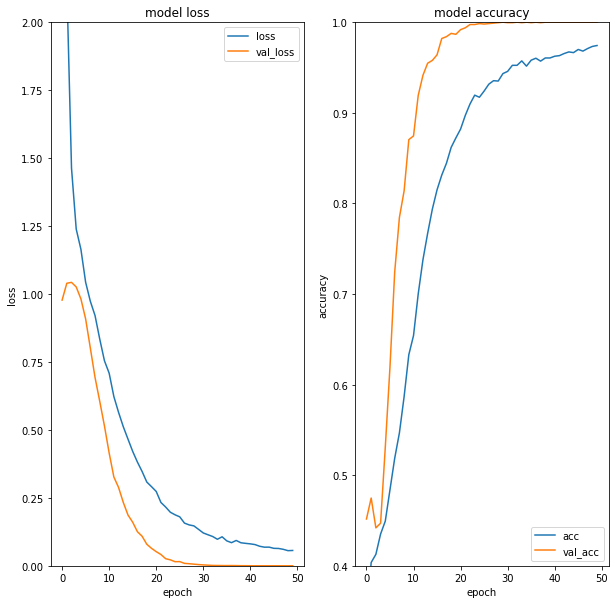

In [93]:
plt.subplot(1, 2, 1)
plt.title('model loss')
plt.plot(hist.history['loss'], label="loss")
plt.plot(hist.history['val_loss'], label="val_loss")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.ylim((0,2))

plt.subplot(1, 2, 2)
plt.title('model accuracy')
plt.plot(hist.history['acc'], label="acc")
plt.plot(hist.history['val_acc'], label="val_acc")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.ylim((0.4, 1))


plt.show();

# 6. 모델 결과 확인

In [94]:
#l_model = load_model('./model_data/VGG_model.h5')

In [95]:
loss_and_metrics = model.evaluate(x_test, y_test, batch_size=BS)
print('## evaluation loss and_metrics ##')
print(loss_and_metrics)

4165/4165 [==============================] - 2s 519us/sample - loss: 4.4334e-04 - acc: 0.9998
## evaluation loss and_metrics ##
[0.0004433369258647911, 0.9997599]


In [96]:
xhat_idx = np.random.choice(x_test.shape[0], 10)
xhat = x_test[xhat_idx]

yhat_classes = model.predict_classes(xhat)

for i in range(10):
    print('True : ' + str(np.argmax(y_test[xhat_idx[i]])) + ', Predict : ' + str(yhat_classes[i]))

True : 1, Predict : 1
True : 2, Predict : 2
True : 1, Predict : 1
True : 0, Predict : 0
True : 1, Predict : 1
True : 0, Predict : 0
True : 1, Predict : 1
True : 2, Predict : 2
True : 0, Predict : 0
True : 1, Predict : 1


# 7. 최종 모델 훈련

In [97]:
x_total = np.vstack((x_train, x_test))
y_total = np.vstack((y_train, y_test))

print(x_total.shape)
print(y_total.shape)

(13883, 64, 64, 3)
(13883, 3)


In [98]:
early_stopping = EarlyStopping(monitor='loss', patience=10)

In [99]:
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=5, min_lr=0.0001)

In [100]:
EPOCHS = 50
INIT_LR = 1e-4
BS = 256
split_ratio = 0.2

print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt,
    metrics=["accuracy"])

[INFO] compiling model...


In [101]:
hist = model.fit(x_total, y_total, 
                 epochs=EPOCHS, batch_size=BS, 
                 #validation_split=split_ratio, 
                 verbose = 1
                 ,callbacks=[reduce_lr]
                )

Train on 13883 samples
Epoch 1/50
13883/13883 [==============================] - 19s 1ms/sample - loss: 0.0603 - acc: 0.9685
Epoch 2/50
13883/13883 [==============================] - 19s 1ms/sample - loss: 0.0525 - acc: 0.9745
Epoch 3/50
13883/13883 [==============================] - 18s 1ms/sample - loss: 0.0541 - acc: 0.9727
Epoch 4/50
13883/13883 [==============================] - 19s 1ms/sample - loss: 0.0505 - acc: 0.9740
Epoch 5/50
13883/13883 [==============================] - 18s 1ms/sample - loss: 0.0532 - acc: 0.9735
Epoch 6/50
13883/13883 [==============================] - 18s 1ms/sample - loss: 0.0521 - acc: 0.9718
Epoch 7/50
13883/13883 [==============================] - 19s 1ms/sample - loss: 0.0511 - acc: 0.9744
Epoch 8/50
13883/13883 [==============================] - 18s 1ms/sample - loss: 0.0492 - acc: 0.9724
Epoch 9/50
13883/13883 [==============================] - 19s 1ms/sample - loss: 0.0476 - acc: 0.9745
Epoch 10/50
13883/13883 [==============================] - 

In [102]:
loss_and_metrics = model.evaluate(x_test, y_test, batch_size=BS)
print('## evaluation loss and_metrics ##')
print(loss_and_metrics)

4165/4165 [==============================] - 2s 533us/sample - loss: 6.0214e-07 - acc: 1.0000
## evaluation loss and_metrics ##
[6.02141996303638e-07, 1.0]


In [103]:
xhat_idx = np.random.choice(x_test.shape[0], 10)
xhat = x_test[xhat_idx]

yhat_classes = model.predict_classes(xhat)

for i in range(10):
    print('True : ' + str(np.argmax(y_test[xhat_idx[i]])) + ', Predict : ' + str(yhat_classes[i]))

True : 0, Predict : 0
True : 2, Predict : 2
True : 0, Predict : 0
True : 1, Predict : 1
True : 1, Predict : 1
True : 1, Predict : 1
True : 1, Predict : 1
True : 2, Predict : 2
True : 1, Predict : 1
True : 1, Predict : 1


# 8. 모델 저장

In [104]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 62, 62, 3)         84        
_________________________________________________________________
batch_normalization_7 (Batch (None, 62, 62, 3)         12        
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 31, 31, 3)         0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 29, 29, 9)         252       
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 14, 14, 9)         0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 12, 12, 18)        1476      
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 6, 6, 18)         

In [105]:
model.save('video_model_3.h5')

In [115]:
model_json=model.to_json()
with open('model1.json','w') as json_file:
    json_file.write(model_json)
    model.save_weights('model1.h5')
print("saved model to disk")

saved model to disk


In [116]:
model_json = model.to_json()
with open("model_test.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_test.h5")
print("Saved model to disk")

Saved model to disk


In [113]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 62, 62, 3)         84        
_________________________________________________________________
batch_normalization_7 (Batch (None, 62, 62, 3)         12        
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 31, 31, 3)         0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 29, 29, 9)         252       
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 14, 14, 9)         0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 12, 12, 18)        1476      
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 6, 6, 18)         

In [107]:
from keras.models import model_from_json
json_file = open('model1.json','r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

TypeError: tuple indices must be integers or slices, not list